In [410]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
import networkx as nx
import math
import random

from e3nn import o3
from tqdm import tqdm
from torch_geometric.datasets import QM9
from torch_geometric.utils import to_networkx, to_undirected
from torch_geometric.data import Data

from cartesian_mace.modules.tensor_contraction_block import CartesianContraction
from cartesian_mace.utils.cartesian_contractions import count_contractions, contraction_is_valid
from cartesian_mace.models.model import CartesianMACE
from src.models import MACEModel
from src.modules.symmetric_contraction import Contraction

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Testing contraction class performance

In [275]:
# define some hyperparameters
max_ell = 2
nu = 4

In the following cell we are setting up the process for running the equivalent contractions for the two contraction classes (not sure if these expressions/irreps are the same?).

We then get an error from the `cg.py` file about a var being referred to before assignment and looking at the `if/elif` statements which need to be true to assign the varaible first we need which doesn't seem to be the case for our 'simple' example

```
for ir, _, base_o3 in wigners:
    if ir in irreps_out and ir == current_ir:
```

In [454]:
# n_indices: tensor product order
# c_out: number of free indices of equivariants
# dim: in dimension of the tensors in (this will be changed at some point)
n_indices = 6
c_out = 0
n_channels = 4
dim=3


cartesian_contraction = CartesianContraction(n_indices=n_indices, c_out=c_out, dim=dim, n_channels=n_channels, split=[n_indices], n_extra_dim=1)
# irreps_in: o3.Irreps,
# irrep_out: o3.Irreps,
# correlation: int,

irreps_in = o3.Irreps([(1,(n_indices, 1))])
irrep_out = o3.Irreps([(1,(c_out, 1))])

spherical_contraction = Contraction(irreps_in=irreps_in, irrep_out=irrep_out, correlation=4) # 'last_ir' referenced before assignment

UnboundLocalError: local variable 'last_ir' referenced before assignment

Here we just run a loop to get an idea of how quick the Cartesian contraction class is for different numbers of indices

In [426]:
results = []
tensors_out = []
n_indices_list = [2,4,6,8,10]

for n_indices in tqdm(n_indices_list):

    shape = [n_channels] + [dim] * n_indices

    tensors_in = torch.randn(shape)

    cartesian_contraction = CartesianContraction(n_indices=n_indices, c_out=c_out, dim=dim, n_channels=n_channels, split=[n_indices], n_extra_dim=1)

    tensors_out.append(cartesian_contraction([tensors_in]))

    timing_result = %timeit -o -q cartesian_contraction([tensors_in])

    results.append(timing_result.average)

print(results)

100%|██████████| 5/5 [00:21<00:00,  4.36s/it]

[1.3752742022853845e-05, 4.625486370038873e-05, 0.00027629996428523947, 0.0022194385699861284, 0.02731072264266134]


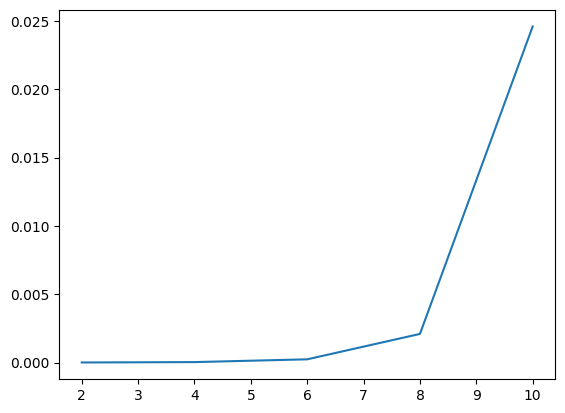

In [278]:
plt.plot(n_indices_list, results)
# plt.yscale('log') # combinatorial relationship
plt.show()

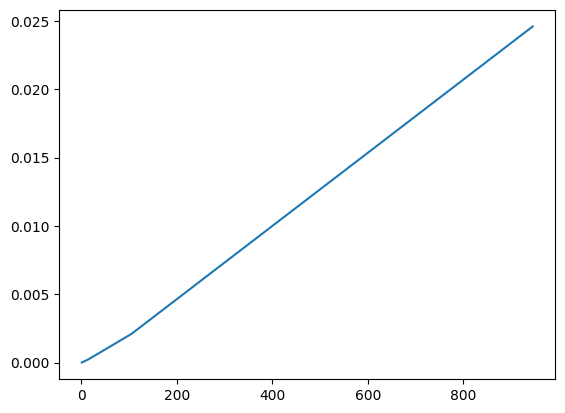

In [279]:
# unsurprisingly, the compute increases linearly with # of contractions
n_contractions = [count_contractions(n_indices, n_indices/2) for n_indices in n_indices_list]

plt.plot(n_contractions, results)
plt.show()

In [280]:
n_contractions == [len(out) for out in tensors_out] # nice!

True

# Testing model performance

Here we can test the model performances of both using the rotational symmetry dataset.

In [445]:
def create_rotsym_envs(fold):
    dataset = []

    batch = torch.LongTensor([0,0,0,0,0])

    # Environment 0
    atoms = torch.LongTensor([ 0 ] + [ 0 ] * fold)
    edge_index = torch.LongTensor( [ [0] * fold, [i for i in range(1, fold+1)] ] )
    x = torch.Tensor([1,0,0])
    pos = [
        torch.Tensor([0,0,0]),  # origin
        x,   # first spoke
    ]
    for count in range(1, fold):
        R = o3.matrix_z(torch.Tensor([2*math.pi/fold * count])).squeeze(0)
        pos.append(x @ R.T)
    pos = torch.stack(pos)
    y = torch.LongTensor([0])  # Label 0
    data1 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y, batch=batch)
    data1.edge_index = to_undirected(data1.edge_index)
    dataset.append(data1)

    # Environment 1
    q = 2*math.pi/(fold + random.randint(1, fold))
    assert q < 2*math.pi/fold
    Q = o3.matrix_z(torch.Tensor([q])).squeeze(0)
    pos = pos @ Q.T
    y = torch.LongTensor([1])  # Label 1
    data2 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y, batch=batch)
    data2.edge_index = to_undirected(data2.edge_index)
    dataset.append(data2)

    return dataset

In [446]:
data = create_rotsym_envs(fold=4)[0]

In [447]:
# hyperparams
n_channels = 4
self_tp_rank_max = 2
basis_rank_max = 2
dim = 3
n_layers = 1
nu_max = 1
feature_rank_max = 2

In [448]:
cmace_results = []
mace_results = []

# hyperparams
n_channels = 4
self_tp_rank_max = 2
basis_rank_max = 2
dim = 3
n_layers = 3
nu_max = 1
feature_rank_max = 2

nu_max_list = [1,2,3,4] # max of 5

for nu_max in tqdm(nu_max_list):

    shape = [n_channels] + [dim] * n_indices

    tensors_in = torch.randn(shape)

    cartesian_mace = CartesianMACE(
        in_dim=2,
        self_tp_rank_max=self_tp_rank_max,
        basis_rank_max=basis_rank_max,
        dim=dim,
        num_layers=n_layers,
        nu_max=nu_max,
        feature_rank_max=feature_rank_max,
    )

    timing_result = %timeit -o -q cartesian_mace(data)
    cmace_results.append(timing_result.average)

    mace = MACEModel(
        scalar_pred=False,
        correlation=nu_max,
        num_layers=n_layers,
        out_dim=2,
        max_ell=self_tp_rank_max,
        emb_dim=n_channels,
    )

    timing_result = %timeit -o -q mace(data)
    mace_results.append(timing_result.average)



  0%|          | 0/4 [00:00<?, ?it/s]/Users/harryshaw/PycharmProjects/geometric-gnn-dojo/venv/lib/python3.9/site-packages/torch/jit/_check.py:181: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "
100%|██████████| 4/4 [00:57<00:00, 14.50s/it]


Here we see `cmace` is much slower than `mace` at large $\nu$ which is not great!. Why could this be? It seems our model scales a lot worse with $\nu$ even though it starts off slightly quicker. Reasons this may be:

- the number of contractions in the Cartesian basis grows much quicker than in the spherical basis
- the scaling of spherical contractions is better than linear (as it is for Cartesian case shown above) -> we will be able to figure this out once we've sorted running the spherical contraction class in isolation
- only point of architecture that feels slower is the use of lists of multi-dimensional tensors instead of flattened features (like in MACE) -> perhaps something to talk about in the report (is it possible to contraction in a linearised for i.e. matrix as `(9,)` tensors, I can't see how because contraction is summing over indices.

would be interesting to hear your thoughts

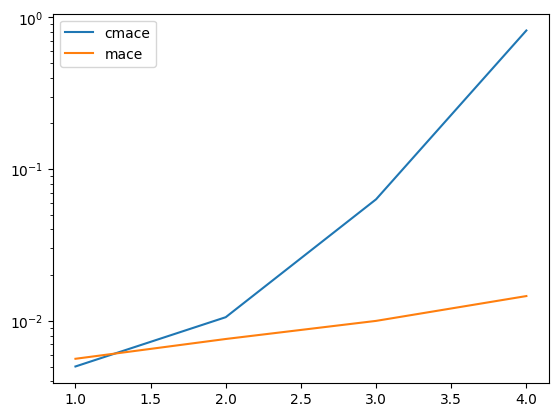

In [452]:
plt.plot(nu_max_list, cmace_results, label='cmace')
plt.plot(nu_max_list, mace_results, label='mace')
plt.yscale('log')
plt.legend()
plt.show()

In [455]:
cmace_results[-1]/mace_results[-1] # 56x slower :/

56.247784391379696

# Theoretical experiments

The rotational symmetry task is finally working! The issue was in how I was aggregating the linearised `h` features at the end. So I've ran all the experiments (apart from $\ell=10, \text{fold}=10$) and got the same results as `TFN/MACE`!

I am now running the $k$-chains experiment which involves running the model with different numbers of layers. Things just don't seem to work and are very random - not sure if I just need to run for more epochs or what. Will get back to you with more results as and when I get them